In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import petl as etl
import anhima
import zarr
import allel
import itertools
import random
import seaborn as sns
import petlx.bio
import csv
import scipy
import intervaltree

/home/randomx/.conda/envs/pyenv1/lib/python3.5/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


In [2]:
call = zarr.open('/mnt/70D89269D8922CFA/Genomes/variation/ag1000g.phase2.ar1.pass.biallelic')
out_alleles = h5py.File('/mnt/70D89269D8922CFA/Genomes/extras/outgroup_alleles_phase2.h5')
ac_count = zarr.open('/mnt/70D89269D8922CFA/Genomes/extras/phase2_biallel_allele_count.zarr/')
out_count = zarr.open('/mnt/70D89269D8922CFA/Genomes/extras/outgroup_alleles_phase2.zarr/')
annotation = zarr.open('/mnt/70D89269D8922CFA/Genomes/variation/ag1000g.phase2.ar1.pass.biallelic_snpeff/')
samples = list(call['3L/samples'])
contigs = ['3L', '3R', '2R', '2L', 'X']
samples = [str(s) for s in call["3L"]["samples"][:]]
tbl_samples = etl.fromcsv('/mnt/70D89269D8922CFA/Genomes/meta/samples.meta.txt', delimiter='\t')

In [3]:
tbl_samples

ox_code,src_code,population,country,location,site,contributor,contact,year,m_s,sex,n_sequences,mean_coverage,ebi_sample_acc,latitude,longitude
AA0040-C,Twifo_Praso__E2,GHcol,Ghana,Twifo Praso,Twifo Praso,David Weetman,David Weetman,2012,M,F,95033368,30.99,ERS311878,5.60858,-1.54926
AA0041-C,Twifo_Praso__H3,GHcol,Ghana,Twifo Praso,Twifo Praso,David Weetman,David Weetman,2012,M,F,95843804,31.7,ERS311886,5.60858,-1.54926
AA0042-C,Takoradi_C7,GHcol,Ghana,Takoradi,Takoradi,David Weetman,David Weetman,2012,M,F,107420666,35.65,ERS311894,4.91217,-1.77397
AA0043-C,Takoradi_H8,GHcol,Ghana,Takoradi,Takoradi,David Weetman,David Weetman,2012,M,F,95993752,29.46,ERS311902,4.91217,-1.77397
AA0044-C,Takoradi_D10,GHcol,Ghana,Takoradi,Takoradi,David Weetman,David Weetman,2012,M,F,103044262,33.67,ERS311910,4.91217,-1.77397


----------------------

In [6]:
m = tbl_samples.select(lambda r: r.m_s == 'M' and r.population == 'GHcol').values('ox_code').list()
s = tbl_samples.select(lambda r: r.m_s == 'S' and r.population == 'GHgam').values('ox_code').list()
index_m = [samples.index(i) for i in m]
index_s = [samples.index(i) for i in s]

In [7]:
print('coluzzii samples:', len(index_m), '\n', 'gambiae samples:', len(index_s))

coluzzii samples: 55 
 gambiae samples: 12


In [8]:
ann = {chrom: annotation[chrom]['variants/ANN_Annotation'][:] for chrom in contigs}

In [9]:
sel = {chrom: ((ann[chrom] != b'intergenic_variant') & (ann[chrom] != b'upstream_gene_variant') &
(ann[chrom] != b'downstream_gene_variant')) for chrom in contigs}

In [10]:
del ann

In [11]:
#Changed from GenotypeDaskArray to GenotypeChunkedArray
ga = {chrom: allel.GenotypeChunkedArray(call[chrom]['calldata/GT']) for chrom in contigs}

In [12]:
# bool biallelic and in genes
is_bial_genes = {chrom: sel[chrom] for chrom in contigs}

In [13]:
#filter to get only biallelic in genes
ga = {chrom: ga[chrom].compress(is_bial_genes[chrom], axis=0) for chrom in contigs}

In [14]:
# get just bf coluzzii individuals
random_index = random.sample(index_m, 12)
gm = {chrom: ga[chrom].take(random_index, axis=1) for chrom in contigs}

In [15]:
#take an equal number of samples
gs = {chrom: ga[chrom].take(index_s, axis=1) for chrom in contigs}

In [16]:
acm = {chrom: gm[chrom].count_alleles() for chrom in contigs}
seg_m = {chrom: acm[chrom].count_segregating() for chrom in contigs}
is_seg_m = {chrom: acm[chrom].is_segregating() for chrom in contigs}

In [17]:
acs = {chrom: gs[chrom].count_alleles() for chrom in contigs}
seg_s = {chrom: acs[chrom].count_segregating() for chrom in contigs}
is_seg_s = {chrom: acs[chrom].is_segregating() for chrom in contigs}

In [18]:
for chrom in contigs:
    print('seg sites coluzii chrom %s:' % chrom, seg_m[chrom])

seg sites coluzii chrom 3L: 886977
seg sites coluzii chrom 3R: 1235126
seg sites coluzii chrom 2R: 1280766
seg sites coluzii chrom 2L: 1028135
seg sites coluzii chrom X: 377105


In [19]:
for chrom in contigs:
    print('seg sites gambiae chrom %s:' % chrom, seg_s[chrom])

seg sites gambiae chrom 3L: 948161
seg sites gambiae chrom 3R: 1336110
seg sites gambiae chrom 2R: 1540742
seg sites gambiae chrom 2L: 1044293
seg sites gambiae chrom X: 418053


In [20]:
#allele frequency
af_gambiae = {chrom: acs[chrom].to_frequencies() for chrom in contigs}

In [21]:
#allele frequency
af_coluzzii = {chrom: acm[chrom].to_frequencies() for chrom in contigs}

In [22]:
outgroups = ['epir', 'chri', 'meru', 'mela']

In [23]:
pos = {chrom: call[chrom]['variants/POS'][:] for chrom in contigs}
pos_bial_genes = {chrom: np.compress(is_bial_genes[chrom], pos[chrom]) for chrom in contigs}

In [24]:
segreg_c = {chrom: np.compress(is_seg_m[chrom], pos_bial_genes[chrom]) for chrom in contigs}
segreg_g = {chrom: np.compress(is_seg_s[chrom], pos_bial_genes[chrom]) for chrom in contigs}

In [25]:
# af biallelic in genes
af_out = {}
for out in outgroups:
    af_out[out] = {}
    for chrom in contigs:
        allele_count = out_count[chrom][out][:]
        allele_count_bial_genes = np.compress(is_bial_genes[chrom], allele_count, axis=0)
        allele_number = allele_count_bial_genes.sum(axis=1)[:, np.newaxis]
        af_out[out][chrom] = np.where(allele_number > 0, allele_count_bial_genes / allele_number, 0)

/home/randomx/.conda/envs/pyenv1/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


In [26]:
#filter bial in genes
out_al = {}
for chrom in contigs:
    out_al[chrom] = {}
    for out in outgroups:
        out_al[chrom][out] = out_alleles[chrom][out][:]
        out_al[chrom][out] = np.compress(is_bial_genes[chrom], out_al[chrom][out])

In [27]:
assert out_al[chrom][out].shape[0] == af_out[out][chrom].shape[0]

In [28]:
def consensus_aa(chrom, out_alleles, outgroups):
    aa = None
    for out in outgroups:
        if aa is None:
            aa = out_alleles[chrom][out]
        else:
            loc_consensus = aa == out_alleles[chrom][out]
            aa[~loc_consensus] = b'.'
    return aa

In [29]:
aa = {chrom: consensus_aa(chrom, out_al, ['chri']) for chrom in contigs}

In [30]:
# load ag1000g alleles
ref = {chrom: call[chrom]['variants/REF'][:] for chrom in contigs}
alt = {chrom: call[chrom]['variants/ALT'][:] for chrom in contigs}

In [31]:
# filter for bial in genes
ref_bial_genes = {chrom: np.compress(is_bial_genes[chrom], ref[chrom]) for chrom in contigs}

alt_bial_genes = {chrom: np.compress(is_bial_genes[chrom], alt[chrom]) for chrom in contigs}

In [32]:
bool_aa_match = {chrom: (aa[chrom] != b'.') & ((aa[chrom] == ref_bial_genes[chrom]) | (aa[chrom] == alt_bial_genes[chrom])) for chrom in contigs}

In [33]:
for chrom in contigs:
    ref[chrom] = ref_bial_genes[chrom][bool_aa_match[chrom]]
    alt[chrom] = alt_bial_genes[chrom][bool_aa_match[chrom]]
    af_coluzzii[chrom] =  af_coluzzii[chrom].compress(bool_aa_match[chrom], axis=0)
    af_gambiae[chrom] = af_gambiae[chrom].compress(bool_aa_match[chrom], axis=0)
    aa[chrom] = aa[chrom][bool_aa_match[chrom]]
    pos_bial_genes[chrom] = pos_bial_genes[chrom][bool_aa_match[chrom]]
    out = 'chri'
    af_out[out][chrom] = af_out[out][chrom][bool_aa_match[chrom]]

In [34]:
bool_no_fixed = {chrom:(((af_out['chri'][chrom][:,1]  != 0) & (af_out['chri'][chrom][:,1] != 1)) 
                        ) for chrom in contigs}

In [35]:
af_gambiae_novar_out = {chrom: np.compress(~bool_no_fixed[chrom], af_gambiae[chrom], axis=0) for chrom in contigs}
af_coluzzii_novar_out = {chrom: np.compress(~bool_no_fixed[chrom], af_coluzzii[chrom], axis=0) for chrom in contigs}
af_novar_out = {}
for out in ['chri']:
        af_novar_out[out] = {chrom: np.compress(~bool_no_fixed[chrom], af_out[out][chrom], axis=0) for chrom in contigs}     

In [36]:
pos_bial_genes = {chrom: np.compress(~bool_no_fixed[chrom], pos_bial_genes[chrom]) for chrom in contigs}

In [37]:
def find_private_fixed_derived_gambiae(pos, af_gambiae, af_coluzzii, af_out, DAF=0.9):
    fixed = {}
    for chrom in contigs:
        cond = ((abs(af_gambiae[chrom][:, 0] - af_coluzzii[chrom][:, 0]) >= DAF) & 
                (abs(af_coluzzii[chrom][:, 0] - af_novar_out['chri'][chrom][:, 0]) <= (1 - DAF)))
        fixed[chrom] = np.compress(cond, pos[chrom])
    return fixed
                                   
                        

In [38]:
def find_private_fixed_derived_coluzzii(pos, af_gambiae, af_coluzzii, af_out, DAF=0.9):
    fixed = {}
    for chrom in contigs:
        cond = ((abs(af_gambiae[chrom][:, 0] - af_coluzzii[chrom][:, 0]) >= DAF) & 
                (abs(af_gambiae[chrom][:, 0] - af_novar_out['chri'][chrom][:, 0]) <= (1 - DAF)))
        fixed[chrom] = np.compress(cond, pos[chrom])
    return fixed
                 

In [39]:
chrom = 'X'
assert(af_gambiae_novar_out[chrom].shape[0] == af_gambiae_novar_out[chrom].shape[0] == pos_bial_genes[chrom].shape[0])

## Sanity Check

In [40]:
fixed_g = find_private_fixed_derived_gambiae(pos_bial_genes, af_gambiae_novar_out, af_coluzzii_novar_out, af_novar_out)
fixed_g['3L']

array([   82544,   138857,   139705,   168829,   296109,   304874,
         305123,   398426,   414547,  1095423,  6945534,  8579061,
        9205129,  9646788,  9647064,  9647117,  9647272,  9647702,
        9647703,  9663586,  9663677,  9663815,  9663847,  9663915,
        9676808,  9683178,  9726102,  9726356, 10274892, 10276680,
       10276935, 10276969, 10276974, 10277001, 10277173, 10280073,
       10280135, 10280145, 10280937, 10387477, 10433175, 10479713,
       10782199, 10883390, 10883931, 10885668, 10885781, 10886677,
       10905456, 11079635, 17619905, 17627681, 35815019], dtype=int32)

In [41]:
fixed_c = find_private_fixed_derived_coluzzii(pos_bial_genes, af_gambiae_novar_out, af_coluzzii_novar_out, af_novar_out)
fixed_c['3L']

array([   66609,    80272,    81082,    82766,   139762,   139768,
         296897,   303760,   304422,   304440,   305059,   377123,
         413508,   413550,   413551,   413944,  6945677,  9188490,
        9251399,  9486722,  9612059,  9647113,  9647382,  9647588,
        9647651,  9647795,  9659308,  9660353,  9662785,  9674850,
        9675276,  9680876,  9683196, 10265423, 10277144, 10277282,
       10278602, 10385594, 10491630, 10882689, 10885503, 10885515,
       11079578, 11079588, 35716799, 35721865, 35723641, 35729856,
       35730304, 35813317, 35815104, 35815144, 35815171, 35815265], dtype=int32)

In [42]:
loc_3L = np.in1d(pos_bial_genes['3L'], fixed_c['3L'])
np.compress(loc_3L, af_coluzzii_novar_out['3L'], axis=0)[:10]

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.]])

In [43]:
np.compress(loc_3L, af_gambiae_novar_out['3L'], axis=0)[:10]

array([[ 0.08333333,  0.91666667],
       [ 0.08333333,  0.91666667],
       [ 0.08333333,  0.91666667],
       [ 0.08333333,  0.91666667],
       [ 0.08333333,  0.91666667],
       [ 0.08333333,  0.91666667],
       [ 0.91666667,  0.08333333],
       [ 0.08333333,  0.91666667],
       [ 0.08333333,  0.91666667],
       [ 0.08333333,  0.91666667]])

In [44]:
np.compress(loc_3L, af_novar_out['chri']['3L'], axis=0)[:10,:2]

array([[ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.]])

-----------------------------

## Stat

In [45]:
def identify_variants_per_gene(chrom, pos, species):
    gff = petlx.bio.gff3.fromgff3('/mnt/70D89269D8922CFA/Genomes/genome/Anopheles-gambiae-PEST_BASEFEATURES_AgamP4.2.gff3.gz')
    gff_chrom = gff.select(lambda r: r.seqid == '%s' % chrom and r.end > r.start and r.type == 'gene')
    array = np.core.records.fromarrays([pos[chrom]], names= 'pos')
    tbl_pos = etl.fromarray(array).convert('pos', int)
    interval_join = etl.intervaljoin(tbl_pos, gff_chrom, lstart='pos', lstop='pos', rstart='start', rstop='end', include_stop=True).sort('pos')
    genes_names = [x["ID"] for x in interval_join['attributes']]
    interval_join = interval_join.addcolumn('genes', genes_names)
    return interval_join

In [46]:
identify_fixex_coluzzii = {chrom: identify_variants_per_gene(chrom, fixed_c, 'coluzzii_segreg') for chrom in contigs}

In [47]:
identify_fixex_gambiae = {chrom: identify_variants_per_gene(chrom, fixed_g, 'coluzzii_segreg') for chrom in contigs}

In [48]:
def count_variants_per_gene(chrom, pos, species):
    gff = petlx.bio.gff3.fromgff3('/mnt/70D89269D8922CFA/Genomes/genome/Anopheles-gambiae-PEST_BASEFEATURES_AgamP4.2.gff3.gz')
    gff_chrom = gff.select(lambda r: r.seqid == '%s' % chrom and r.end > r.start and r.type == 'gene')
    array = np.core.records.fromarrays([pos[chrom]], names= 'pos')
    tbl_pos = etl.fromarray(array).convert('pos', int)
    interval_join = etl.intervaljoin(tbl_pos, gff_chrom, lstart='pos', lstop='pos', rstart='start', rstop='end', include_stop=True).sort('pos')
    genes_names = [x["ID"] for x in interval_join['attributes']]
    interval_join = interval_join.addcolumn('genes', genes_names)
    aggregate = interval_join.aggregate('genes', len).rename('value', species)
    return aggregate

In [49]:
#A
count_segreg_coluzzii = {chrom: count_variants_per_gene(chrom, segreg_c, 'coluzzii_segreg') for chrom in contigs}

In [50]:
#B
count_segreg_gambiae = {chrom: count_variants_per_gene(chrom, segreg_g, 'gambiae_segreg') for chrom in contigs}

In [51]:
#C
count_fixed_coluzzii = {chrom: count_variants_per_gene(chrom, fixed_c, 'coluzzii_fixed') for chrom in contigs}

In [52]:
#D
count_fixed_gambiae = {chrom: count_variants_per_gene(chrom, fixed_g, 'gambiae_fixed') for chrom in contigs}

In [53]:
# join (A and C) - (B and D)
joi_seg_fix_coluzzii = {chrom: count_fixed_coluzzii[chrom].join(count_segreg_coluzzii[chrom], key='genes') for chrom in contigs}
joi_seg_fix_gambiae  = {chrom: count_fixed_gambiae[chrom].join(count_segreg_gambiae[chrom], key='genes') for chrom in contigs}

In [54]:
# calculate the ratio for each gene
joi_seg_fix_coluzzii= {chrom: joi_seg_fix_coluzzii[chrom].addfield('A/C (i.e.seg/fix)', lambda r: r.coluzzii_segreg / r.coluzzii_fixed)
                       for chrom in contigs}
joi_seg_fix_gambiae= {chrom: joi_seg_fix_gambiae[chrom].addfield('B/D (i.e.seg/fix)', lambda r: r.gambiae_segreg / r.gambiae_fixed)
                       for chrom in contigs}
joi_seg_fix_coluzzii['2R'].display()
joi_seg_fix_gambiae['2R'].display()

genes,coluzzii_fixed,coluzzii_segreg,A/C (i.e.seg/fix)
AGAP001658,1,222,222.0
AGAP001660,1,940,940.0
AGAP001674,4,744,186.0
AGAP001675,1,37,37.0
AGAP001678,2,1045,522.5


genes,gambiae_fixed,gambiae_segreg,B/D (i.e.seg/fix)
AGAP001569,1,73,73.0
AGAP001658,1,350,350.0
AGAP001660,2,1390,695.0
AGAP001673,2,146,73.0
AGAP001674,1,1161,1161.0


In [55]:
etl.rowlengths(joi_seg_fix_gambiae['X'])

length,count
4,102


In [56]:
# calculate ABCD genome wide (in all genes with both fixed and segregating variants)
A_geno_wide_coluzzii = sum([joi_seg_fix_coluzzii[chrom].stats('coluzzii_segreg')[2] for chrom in contigs])
C_geno_wide_coluzzii = sum([joi_seg_fix_coluzzii[chrom].stats('coluzzii_fixed')[2] for chrom in contigs])
B_geno_wide_gambiae = sum([joi_seg_fix_gambiae[chrom].stats('gambiae_segreg')[2] for chrom in contigs])
D_geno_wide_gambiae = sum([joi_seg_fix_gambiae[chrom].stats('gambiae_fixed')[2] for chrom in contigs])

In [57]:
# calculate A/C and B/D genome wide
AC_geno_wide = A_geno_wide_coluzzii / C_geno_wide_coluzzii
print('\n', 'A genome wide: ', A_geno_wide_coluzzii, '\n', 'C genome wide: ', C_geno_wide_coluzzii, '\n', 'A/C genome wide: ', AC_geno_wide)
BD_geno_wide = B_geno_wide_gambiae / D_geno_wide_gambiae
print('\n', 'B genome wide: ', B_geno_wide_gambiae, '\n', 'D genome wide: ', D_geno_wide_gambiae, '\n', 'B/D genome wide: ', BD_geno_wide)


 A genome wide:  97593.0 
 C genome wide:  820.0 
 A/C genome wide:  119.01585365853659

 B genome wide:  102736.0 
 D genome wide:  724.0 
 B/D genome wide:  141.90055248618785


In [58]:
def get_conti(chrom, species, joi_seg_fix, seg_geno_wide, fixed_geno_wide):
    conti_tbl = {}
    for rec in joi_seg_fix[chrom].records():
        if species == 'coluzzii':
            A = rec.coluzzii_segreg
            C = rec.coluzzii_fixed
            gene = rec.genes
            conti_tbl[gene] = [[A, C], [seg_geno_wide, fixed_geno_wide]]
        if species == 'gambiae':
            B = rec.gambiae_segreg
            D = rec.gambiae_fixed
            gene = rec.genes
            conti_tbl[gene] = [[B, D], [seg_geno_wide, fixed_geno_wide]]
    return conti_tbl

In [59]:
def perform_pear_chi(species):
    pear_chi = {}
    conti_tbl = {}
    for chrom in contigs:
        if species == 'coluzzii':
            conti_tbl[chrom] = get_conti(chrom, 'coluzzii', joi_seg_fix_coluzzii, A_geno_wide_coluzzii, C_geno_wide_coluzzii)
        if species == 'gambiae':
            conti_tbl[chrom] = get_conti(chrom, 'gambiae', joi_seg_fix_gambiae, B_geno_wide_gambiae, D_geno_wide_gambiae)
        pear_chi[chrom] = {}
        for k in conti_tbl[chrom]:
            pear_chi[chrom][k] = scipy.stats.chi2_contingency(conti_tbl[chrom][k])
    return pear_chi

In [60]:
pear_chi_coluzzii = perform_pear_chi('coluzzii')
pear_chi_gambiae = perform_pear_chi('gambiae')

In [61]:
conti_tbl_coluzzii = {}
conti_tbl_gambiae = {}
for chrom in contigs:
    conti_tbl_gambiae[chrom] = get_conti(chrom, 'gambiae', joi_seg_fix_gambiae, B_geno_wide_gambiae, D_geno_wide_gambiae)
    conti_tbl_coluzzii[chrom] = get_conti(chrom, 'coluzzii', joi_seg_fix_coluzzii, A_geno_wide_coluzzii, C_geno_wide_coluzzii)

In [62]:
with open('/home/randomx/hka/gambiae_hka_summary_beta.tab', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter='\t')
    header = ['chrom', 'gene', 'segreg_g', 'pri_der_fix_g', 'score_g']
    writer.writerow(header)
    for chrom in contigs:
        for gene, value in pear_chi_gambiae[chrom].items():
            row = [chrom, gene, conti_tbl_gambiae[chrom][gene][0][0], conti_tbl_gambiae[chrom][gene][0][1], -(np.log10((value[1])))]
            writer.writerow(row)


In [63]:
with open('/home/randomx/hka/coluzzii_hka_summary.tab_beta.tab', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter='\t')
    header = ['chrom', 'gene', 'segreg_c', 'pri_der_fix_c', 'score_c']
    writer.writerow(header)
    for chrom in contigs:
        for gene, value in pear_chi_coluzzii[chrom].items():
            row = [chrom, gene, conti_tbl_coluzzii[chrom][gene][0][0], conti_tbl_coluzzii[chrom][gene][0][1], -(np.log10((value[1])))]
            writer.writerow(row)


------------------------------------------------------------

In [64]:
hka_gambiae = etl.fromtsv('/home/randomx/hka/gambiae_hka_summary_beta.tab', delimiter='\t')
hka_gambiae.convert('score_g', float).select(lambda rec: rec.score_g >= 1.3).displayall()

chrom,gene,segreg_g,pri_der_fix_g,score_g
3L,AGAP010313,51,3,3.26222692422
3L,AGAP010316,4,1,1.89717023479
3L,AGAP010744,29,4,11.0035709482
3L,AGAP010781,153,4,1.65945871756
3R,AGAP007731,41,10,51.8093490646
3R,AGAP007738,31,5,16.5881423296
3R,AGAP007761,392,8,2.29569295125
3R,AGAP010286,138,7,7.26817349598
3R,AGAP007737,45,6,17.1121703985
3R,AGAP010307,70,3,2.27360584674


In [65]:
hka_coluzzii = etl.fromtsv('/home/randomx/hka/coluzzii_hka_summary.tab_beta.tab', delimiter='\t')
hka_coluzzii.displayall()

chrom,gene,segreg_c,pri_der_fix_c,score_c
3L,AGAP010313,29,5,14.6636952331
3L,AGAP028193,1,1,3.76542401325
3L,AGAP010310,28,3,5.00758824223
3L,AGAP011979,61,4,4.2472868475
3L,AGAP010317,5,4,35.2866188905
3L,AGAP010744,9,2,5.51183801581
3L,AGAP010788,522,1,0.769842677587
3L,AGAP010780,89,1,0.112547809778
3L,AGAP011974,49,1,0.0471344833923
3L,AGAP010797,421,1,0.551178165794


In [66]:
hka_gambiae.convert('score_g', float).select(lambda r: (r.chrom == 'X') & (r.score_g >= 1.3)).rowlengths() 

length,count
5,63


In [67]:
hka_coluzzii.convert('score_c', float).select(lambda r: (r.chrom == 'X') & (r.score_c >= 1.3)).rowlengths() 

length,count
5,60


-----------------------------

## Distruptive selection

In [68]:
direct_select = (hka_coluzzii.join(hka_gambiae, key=['chrom', 'gene'])
    .convert(['score_c', 'score_g'], float)
    #.select(lambda r: (r.score_g >= 10) & (r.score_c >= 10))
    .addfield('score_tot', lambda r: r.score_c + r.score_g)
    .sort('score_tot', reverse=True)
    )
direct_select.tocsv('/home/randomx/hka/putative_directional_selection_beta.tab', delimiter='\t')
direct_select.display(10)

chrom,gene,segreg_c,pri_der_fix_c,score_c,segreg_g,pri_der_fix_g,score_g,score_tot
3R,AGAP007732,125,23,79.5081914598,162,32,141.691888767,221.2000802268
X,AGAP001035,16,13,135.557066942,25,6,29.0596679629,164.6167349049
X,AGAP013341,11,10,108.963213464,7,4,34.296035244,143.259248708
3R,AGAP007736,663,47,58.9857363828,859,56,77.8088307414,136.7945671242
X,AGAP001076,36,10,48.1812876155,26,10,74.5961305338,122.77741814929999
3R,AGAP007731,32,11,63.3604541428,41,10,51.8093490646,115.16980320740001
X,AGAP001037,2,4,53.1704111578,9,2,6.56062246279,59.73103362059
X,AGAP001026,10,5,34.5258951848,11,4,25.0028562946,59.5287514794
X,AGAP001041,1,1,3.76542401325,1,3,48.8133325277,52.578756540949996
2R,AGAP004643,32,5,13.3873816412,12,4,23.4034315739,36.7908132151


In [69]:
direct_select = (hka_coluzzii.join(hka_gambiae, key=['chrom', 'gene'])
    .convert(['score_c', 'score_g'], float)
    .select(lambda r: (r.score_g >= 10) & (r.score_c >= 10))
    .addfield('score_tot', lambda r: r.score_c + r.score_g)
    .sort('score_tot', reverse=True))
direct_select.tocsv('/home/randomx/hka/putative_directional_selection_beta.tab', delimiter='\t')
direct_select.displayall()

chrom,gene,segreg_c,pri_der_fix_c,score_c,segreg_g,pri_der_fix_g,score_g,score_tot
3R,AGAP007732,125,23,79.5081914598,162,32,141.691888767,221.2000802268
X,AGAP001035,16,13,135.557066942,25,6,29.0596679629,164.6167349049
X,AGAP013341,11,10,108.963213464,7,4,34.296035244,143.259248708
3R,AGAP007736,663,47,58.9857363828,859,56,77.8088307414,136.7945671242
X,AGAP001076,36,10,48.1812876155,26,10,74.5961305338,122.77741814929999
3R,AGAP007731,32,11,63.3604541428,41,10,51.8093490646,115.16980320740001
X,AGAP001026,10,5,34.5258951848,11,4,25.0028562946,59.5287514794
2R,AGAP004643,32,5,13.3873816412,12,4,23.4034315739,36.7908132151
X,AGAP001043,140,12,18.9050629356,127,9,13.9222079773,32.8272709129
X,AGAP001092,5,3,20.4581818734,4,2,12.0001883949,32.4583702683


## Indentify genes which experienced private selection

In [70]:
hka_gambiae_coluzzii = hka_coluzzii.outerjoin(hka_gambiae, key=['chrom', 'gene']).convert(['score_g', 'score_c'], float)
priv_sel_coluzzii =  (hka_gambiae_coluzzii.selectne('score_c', None).convert('score_g', {None: 0})
                     .select(lambda r: r.score_c >= 1.3 and r.score_g <= 1.3).sort('score_c', reverse=True))
priv_sel_coluzzii.displayall()

chrom,gene,segreg_c,pri_der_fix_c,score_c,segreg_g,pri_der_fix_g,score_g
3L,AGAP010317,5,4,35.2866188905,11,1,0.823886240214
X,AGAP013181,14,5,27.0550960852,None,None,0
3R,AGAP010302,12,4,19.5950729614,28,1,0.293600660746
X,AGAP001031,8,3,14.8126380389,8,1,1.09266442142
3R,AGAP010304,18,4,14.0712675821,None,None,0
X,AGAP000989,23,4,11.3352927191,None,None,0
2R,AGAP003509,3430,1,6.42406149542,None,None,0
X,AGAP000988,8,2,6.0678385129,None,None,0
X,AGAP001025,24,3,5.81601191381,27,1,0.308819608086
X,AGAP000994,25,3,5.5925604973,25,1,0.342193222438


In [71]:
priv_sel_gambiae =  (hka_gambiae_coluzzii.selectne('score_g', None).convert('score_c', {None: 0})
                     .select(lambda r: r.score_g >= 1.3 and r.score_c <= 1.3).sort('score_g', reverse=True))
priv_sel_gambiae.displayall()

chrom,gene,segreg_c,pri_der_fix_c,score_c,segreg_g,pri_der_fix_g,score_g
X,AGAP000975,None,None,0,14,5,32.3304107603
X,AGAP000949,None,None,0,11,4,25.0028562946
X,AGAP001068,27,1,0.236803556905,13,4,21.9914805256
X,AGAP001083,9,1,0.831281434198,6,3,21.6263518313
3R,AGAP010308,None,None,0,32,5,16.111339143
X,AGAP001023,56,2,0.846132803417,118,9,15.0886227625
X,AGAP000983,20,1,0.360847479018,26,4,12.1752796255
X,AGAP000984,None,None,0,55,5,9.51751576914
X,AGAP001042,None,None,0,6,2,9.01775422166
X,AGAP001051,None,None,0,6,2,9.01775422166


## Plot genome wide HKA

In [72]:
def center_pos(r):
    start = r.start
    end = r.end
    center = ((end - start) / 2) + start
    return int(center)

In [73]:
tbl_genes  = (etl
    .fromgff3('/mnt/70D89269D8922CFA/Genomes/genome/Anopheles-gambiae-PEST_BASEFEATURES_AgamP4.2.gff3.gz')
    .unpackdict('attributes')
    .cut(2,3,4,9)
    .select(lambda rec: rec.type == 'gene')
    .rename('ID', 'gene')
    .addfield('center_gene', center_pos)
)
tbl_genes.display(10)

type,start,end,gene,center_gene
gene,157348,186936,AGAP004677,172142
gene,203779,205293,AGAP004678,204536
gene,207894,210460,AGAP004679,209177
gene,271285,271815,AGAP004680,271550
gene,358329,359280,AGAP004681,358804
gene,433503,461627,AGAP004682,447565
gene,485698,488369,AGAP004683,487033
gene,493039,493543,AGAP004684,493291
gene,493579,497632,AGAP004685,495605
gene,742004,747057,AGAP004686,744530


In [74]:
pos_hka_gambiae = hka_gambiae.join(tbl_genes, key='gene')
pos_hka_coluzzii = hka_coluzzii.join(tbl_genes, key='gene')

In [75]:
def plot_genome_hka(species, chrom):
    if species == 'gambiae':   
        tbl_plot = pos_hka_gambiae.select(lambda r: r.chrom == chrom)
        y = tbl_plot['score_g'].list()
    if species == 'coluzzii':
        tbl_plot = pos_hka_coluzzii.select(lambda r: r.chrom == chrom)
        y = tbl_plot['score_c'].list()
    fig, ax = plt.subplots(figsize=(15,2))
    x = tbl_plot['center_gene'].list()
    
    ax.set_ylabel('HKA test score', fontsize=14)
    ax.set_xlabel('Positions', fontsize=14)
    ax.set_title('An. gambiae chrom: %s' % chrom, fontsize=14)
    ax.plot(x, y, 'or')
    len_chrom = {'X': 244e5, '3R': 532e5, '3L': 42e6, '2R': 616e5, '2L':493e5}
    ax.set_xlim(0, len_chrom[chrom])
    if chrom == 'X':
        ax.set_ylim(0, 80)
    else:
        ax.set_ylim(0, 40)
    sns.despine(offset=10)

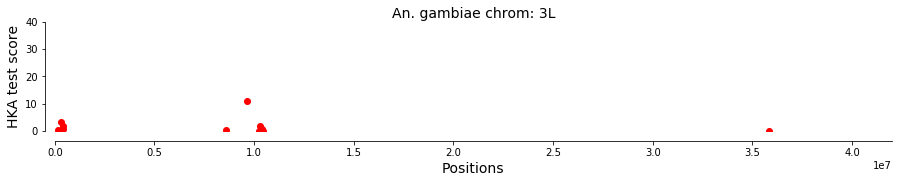

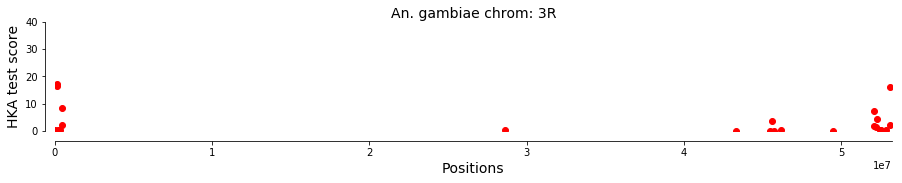

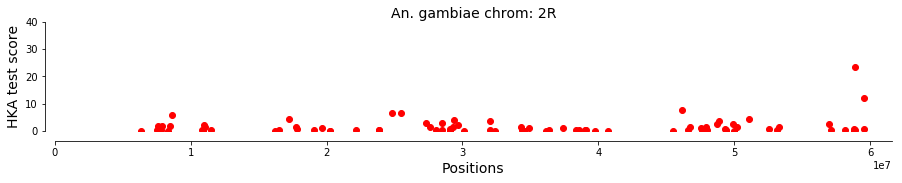

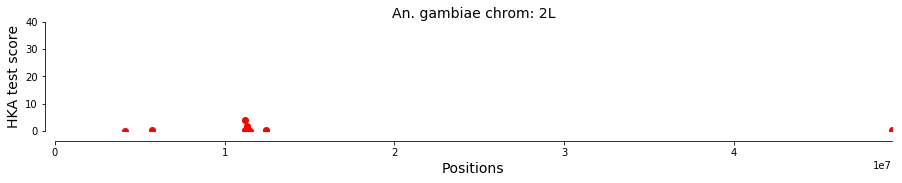

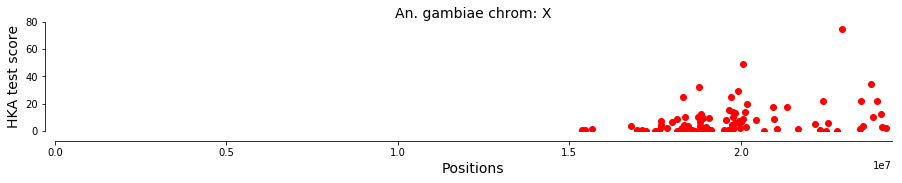

In [76]:
for chrom in contigs:
    plot_genome_hka('gambiae', chrom)

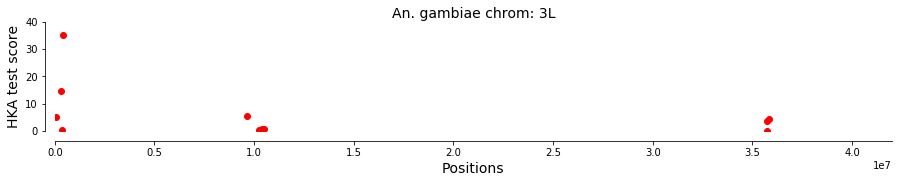

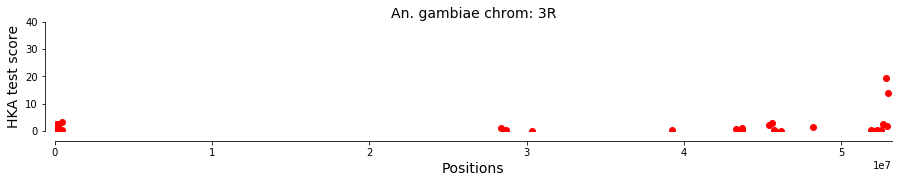

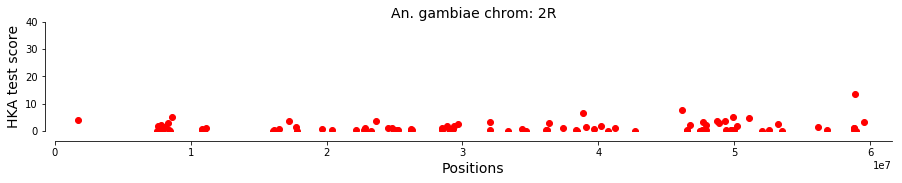

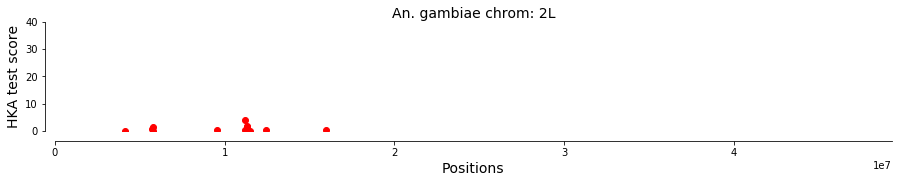

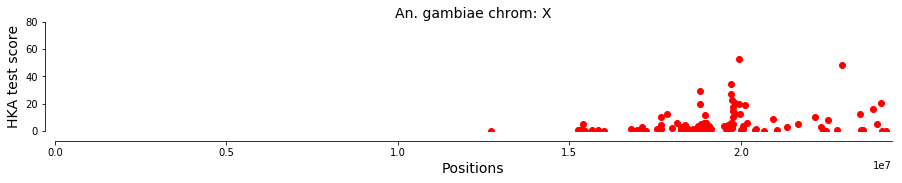

In [77]:
for chrom in contigs:
    plot_genome_hka('coluzzii', chrom)

## Plot seg fixed An coluzzii

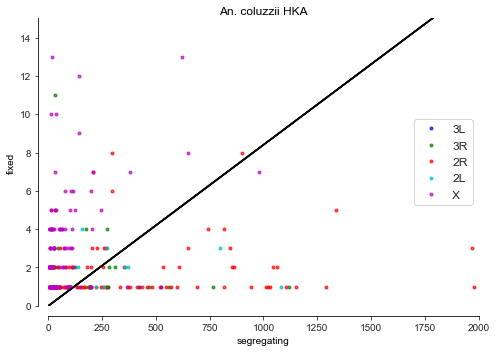

In [78]:
fig, ax = plt.subplots(figsize=(7,5))
for num, chrom in enumerate(contigs):
    
    colour = {0:'b', 1:'g', 2:'r', 3: 'c', 4:'m'}
    conti_tbl = get_conti(chrom, 'coluzzii', joi_seg_fix_coluzzii, A_geno_wide_coluzzii, C_geno_wide_coluzzii)
    segreg = [i[0][0] for i in conti_tbl.values()]
    fixed = [i[0][1] for i in conti_tbl.values()]
    ax.plot(segreg, fixed,  colour[num] + '.', alpha=0.7, label=chrom)
    ax.plot([0, A_geno_wide_coluzzii], [0, C_geno_wide_coluzzii], 'k')
    ax.set_xlabel('segregating')
    ax.set_xlim(0,2000)
    ax.set_ylim(0,15)
    ax.set_title('An. coluzzii HKA')
    ax.set_ylabel('fixed')
    sns.set_style('ticks')
    ax.legend(loc=7, fontsize='large')
    sns.despine(offset=10)

fig.tight_layout()

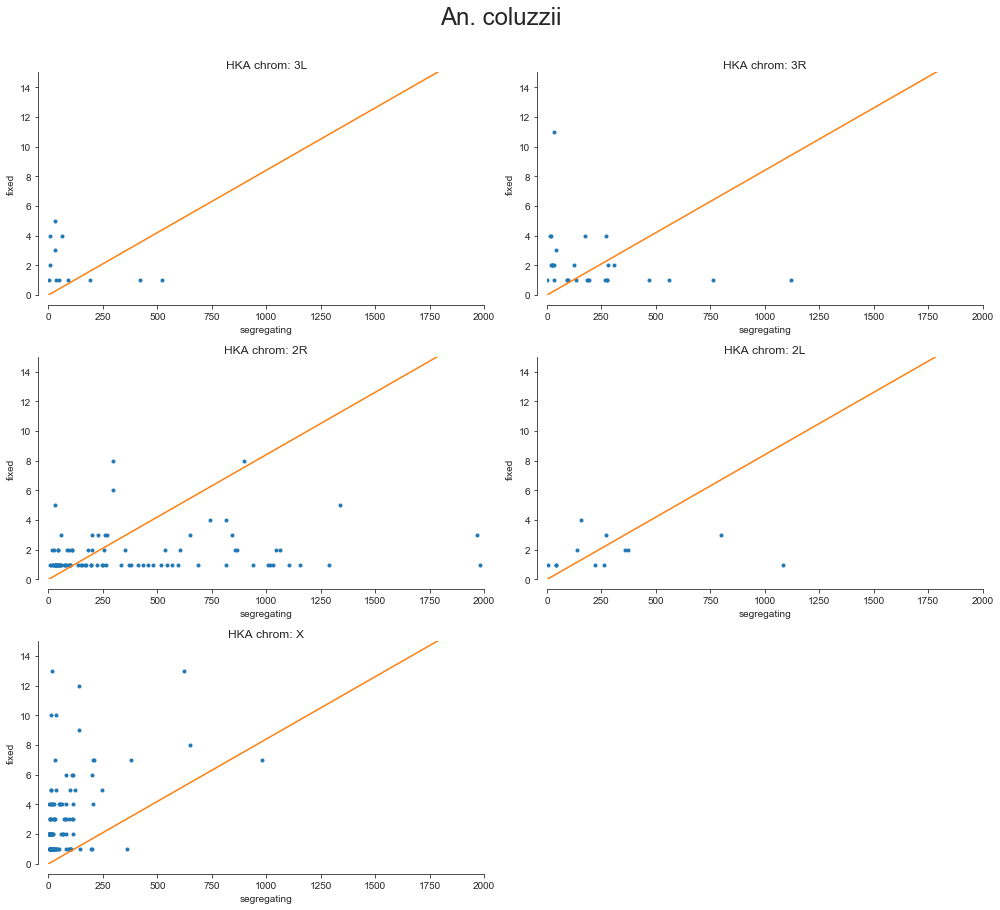

In [79]:
fig = plt.figure(figsize=(14, 12))
for num, chrom in enumerate(contigs):
    
    ax = plt.subplot(3,2,num+1)
    conti_tbl = get_conti(chrom, 'coluzzii', joi_seg_fix_coluzzii, A_geno_wide_coluzzii, C_geno_wide_coluzzii)
    segreg = [i[0][0] for i in conti_tbl.values()]
    fixed = [i[0][1] for i in conti_tbl.values()]
    ax.plot(segreg, fixed, '.')
    ax.plot([0, A_geno_wide_coluzzii], [0, C_geno_wide_coluzzii])
    ax.set_xlabel('segregating')
    ax.set_xlim(0,2000)
    ax.set_ylim(0,15)
    ax.set_title('HKA chrom: %s' % chrom)
    ax.set_ylabel('fixed')
    sns.set_style('ticks')
    sns.despine(offset=10)
fig.suptitle('An. coluzzii', y=1.05, fontsize=24)
fig.tight_layout()

## Plot seg fixed An. gambiae

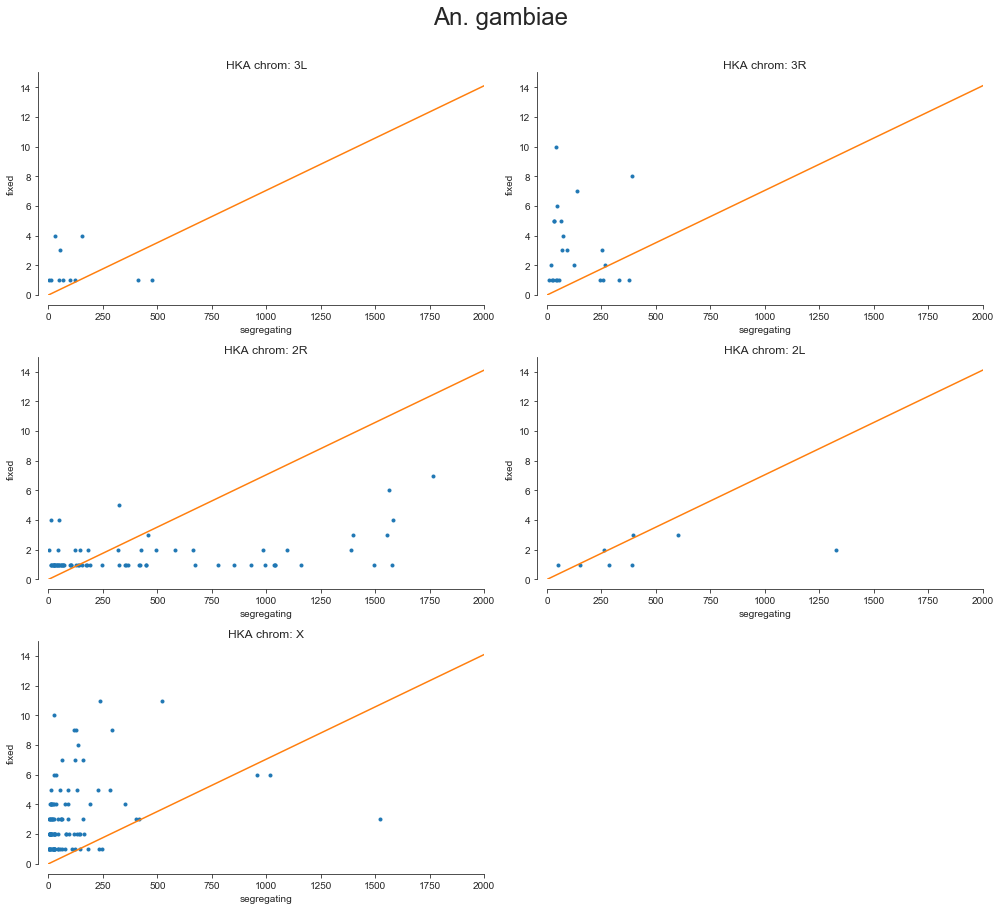

In [80]:
fig = plt.figure(figsize=(14, 12))
for num, chrom in enumerate(contigs):
    
    ax = plt.subplot(3,2,num+1)
    conti_tbl = get_conti(chrom, 'gambiae', joi_seg_fix_gambiae, B_geno_wide_gambiae, D_geno_wide_gambiae)
    segreg = [i[0][0] for i in conti_tbl.values()]
    fixed = [i[0][1] for i in conti_tbl.values()]
    ax.plot(segreg, fixed, '.')
    ax.plot([0, B_geno_wide_gambiae], [0, D_geno_wide_gambiae])
    ax.set_xlabel('segregating')
    ax.set_xlim(0,2000)
    ax.set_ylim(0,15)
    ax.set_title('HKA chrom: %s' % chrom)
    ax.set_ylabel('fixed')
    sns.set_style('ticks')
    sns.despine(offset=10)
fig.suptitle('An. gambiae', y=1.05, fontsize=24)
fig.tight_layout()

## Plot homogeneity test

In [81]:
# get just the gene matching gambiae coluzzii
joi_gambiae_coluzzii = {chrom: joi_seg_fix_coluzzii[chrom].join(joi_seg_fix_gambiae[chrom], key='genes') for chrom in contigs}

In [82]:
joi_gambiae_coluzzii['2L'].display()

genes,coluzzii_fixed,coluzzii_segreg,A/C (i.e.seg/fix),gambiae_fixed,gambiae_segreg,B/D (i.e.seg/fix)
AGAP004827,2,357,178.5,3,397,132.33333333333334
AGAP004902,3,799,266.3333333333333,3,601,200.33333333333334
AGAP005165,5,3042,608.4,4,3212,803.0
AGAP005168,2,136,68.0,1,152,152.0
AGAP005170,1,1083,1083.0,2,1325,662.5


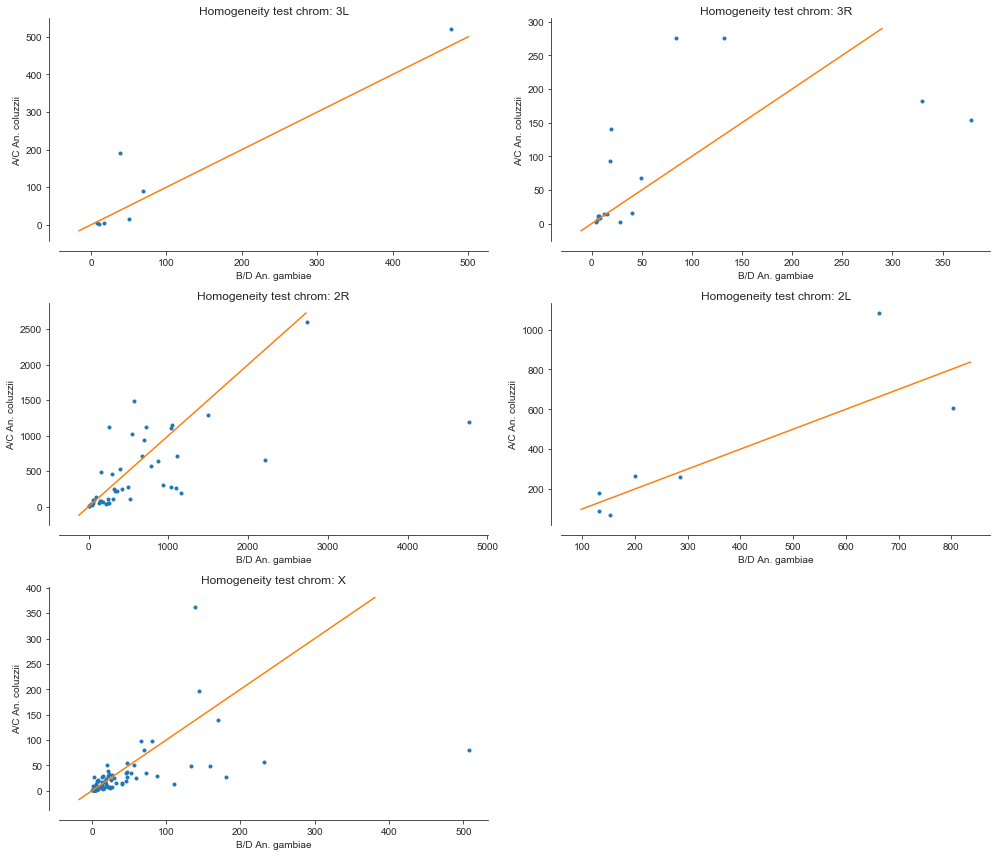

In [83]:
fig = plt.figure(figsize=(14, 12))
for num, chrom in enumerate(contigs):
    
    ax = plt.subplot(3,2,num+1)
    
    AC = joi_gambiae_coluzzii[chrom]['A/C (i.e.seg/fix)'].list()
    BD = joi_gambiae_coluzzii[chrom]['B/D (i.e.seg/fix)'].list()
    fixed = [i[0][1] for i in conti_tbl.values()]
    ax.plot(BD, AC, '.')
    lim = max(ax.get_xlim(), ax.get_ylim())
    ax.plot(lim, lim)
    #ax.set_xlim(0,2000)
    #ax.set_ylim(0,2000)
    ax.set_title('Homogeneity test chrom: %s' % chrom)
    ax.set_ylabel('A/C An. coluzzii')
    ax.set_xlabel('B/D An. gambiae')
    sns.set_style('ticks')
    sns.despine(offset=10)

fig.tight_layout()

## Homogeneity test

In [84]:
joi_gambiae_coluzzii[chrom]

genes,coluzzii_fixed,coluzzii_segreg,A/C (i.e.seg/fix),gambiae_fixed,gambiae_segreg,B/D (i.e.seg/fix)
AGAP000829,3,81,27.0,1,180,180.0
AGAP000833,4,54,13.5,1,110,110.0
AGAP000837,1,98,98.0,2,132,66.0
AGAP000847,8,648,81.0,3,1521,507.0
AGAP000893,3,96,32.0,5,133,26.6


In [85]:
def perform_homogen(joi_g_c):
    conti_tbl = {}
    pear_chi = {}
    for chrom in contigs:
        conti_tbl[chrom] = {}
        pear_chi[chrom] = {}
        for rec in joi_g_c[chrom].records():

            A = rec.coluzzii_segreg
            C = rec.coluzzii_fixed
            B = rec.gambiae_segreg
            D = rec.gambiae_fixed
            gene = rec.genes
            conti_tbl[chrom][gene] = [[A, B], [C, D]]
        for k in conti_tbl[chrom]:
            pear_chi[chrom][k] = scipy.stats.chi2_contingency(conti_tbl[chrom][k])
    return pear_chi

In [86]:
pear_chi_homogen = perform_homogen(joi_gambiae_coluzzii)

In [87]:
with open('/home/randomx/hka/homogen_test/homogeneity_summary_beta.tab', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter='\t')
    header = ['chrom', 'gene','score']
    writer.writerow(header)
    for chrom in contigs:
        for gene, value in pear_chi_homogen[chrom].items():
            row = [chrom, gene, -(np.log10((value[1])))]
            writer.writerow(row)


In [88]:
homog_tbl = (etl.fromtsv('/home/randomx/hka/homogen_test/homogeneity_summary_beta.tab', delimiter='\t')
             .convert('score', float)
             #.select(lambda r: r.score >= 1)
             .sort(['chrom', 'score'], reverse=True)
             )
homog_tbl.displayall()

chrom,gene,score
X,AGAP000847,2.23983390628
X,AGAP000998,1.7040751304
X,AGAP001035,1.18388441034
X,AGAP000833,1.0553664076
X,AGAP001068,0.939424447799
X,AGAP000981,0.910675579703
X,AGAP001015,0.851881841512
X,AGAP001037,0.847455683778
X,AGAP000829,0.739493097153
X,AGAP001061,0.688814671249


In [89]:
join_hom_direct = homog_tbl.join(direct_select, key='gene')
join_hom_direct.displayall()

chrom,gene,score,chrom,segreg_c,pri_der_fix_c,score_c,segreg_g,pri_der_fix_g,score_g,score_tot
X,AGAP001026,-0.0,X,10,5,34.5258951848,11,4,25.0028562946,59.5287514794
X,AGAP001029,0.0672119372577,X,14,4,17.3467593917,22,4,14.1551706778,31.5019300695
X,AGAP001033,0.116001204253,X,3,2,12.112300161,12,3,12.8753978587,24.987698019699998
X,AGAP001035,1.18388441034,X,16,13,135.557066942,25,6,29.0596679629,164.6167349049
X,AGAP001043,0.0705962674491,X,140,12,18.9050629356,127,9,13.9222079773,32.8272709129
X,AGAP001076,0.149188133262,X,36,10,48.1812876155,26,10,74.5961305338,122.77741814929999
X,AGAP001090,-0.0,X,15,4,16.399296884,16,3,10.097279258,26.496576142000002
X,AGAP001092,0.162861270783,X,5,3,20.4581818734,4,2,12.0001883949,32.4583702683
2R,AGAP004643,0.273570955811,2R,32,5,13.3873816412,12,4,23.4034315739,36.7908132151
3R,AGAP007731,0.182489485653,3R,32,11,63.3604541428,41,10,51.8093490646,115.16980320740001


---------------------------

## Homogen selection coluzzii: (C/A > D/B)

In [90]:
for chrom in contigs:
    joi_gambiae_coluzzii[chrom] = joi_gambiae_coluzzii[chrom].addfield('chrom', chrom)


In [91]:
joi_g_c_genome = etl.cat(*joi_gambiae_coluzzii.values())
joi_g_c_genome.display()

genes,coluzzii_fixed,coluzzii_segreg,A/C (i.e.seg/fix),gambiae_fixed,gambiae_segreg,B/D (i.e.seg/fix),chrom
AGAP010313,5,29,5.8,3,51,17.0,3L
AGAP010317,4,5,1.25,1,11,11.0,3L
AGAP010744,2,9,4.5,4,29,7.25,3L
AGAP010780,1,89,89.0,1,69,69.0,3L
AGAP010781,1,192,192.0,4,153,38.25,3L


In [92]:
homogen_select_coluzzii = (joi_g_c_genome.addfield('C/A', lambda r: r.coluzzii_fixed / r.coluzzii_segreg)
                     .addfield('D/B', lambda r: r.gambiae_fixed / r.gambiae_segreg)
                     .select(lambda r: r['C/A'] > r['D/B'])
                     .rename('genes', 'gene')
                     .join(homog_tbl, key=['gene', 'chrom'])
                     .cut(0,7,-1)
                     .sort('score', reverse=True)
                     )
homogen_select_coluzzii.displayall()

gene,chrom,score
AGAP003997,2R,3.32224702314
AGAP001824,2R,2.37502193524
AGAP001683,2R,2.36392372239
AGAP000847,X,2.23983390628
AGAP000998,X,1.7040751304
AGAP003349,2R,1.52558947398
AGAP001690,2R,1.51786532099
AGAP001035,X,1.18388441034
AGAP003519,2R,1.15753654592
AGAP002915,2R,1.13572300768


In [93]:
homogen_select_gambiae = (joi_g_c_genome.addfield('C/A', lambda r: r.coluzzii_fixed / r.coluzzii_segreg)
                     .addfield('D/B', lambda r: r.gambiae_fixed / r.gambiae_segreg)
                     .select(lambda r: r['D/B'] > r['C/A'])
                     .rename('genes', 'gene')
                     .join(homog_tbl, key=['gene', 'chrom'])
                     .cut(0,7,-1)
                     .sort('score', reverse=True)
                     )
homogen_select_gambiae.displayall()

gene,chrom,score
AGAP010286,3R,1.8605579685
AGAP004066,2R,1.04518913475
AGAP001068,X,0.939424447799
AGAP010781,3L,0.593667230737
AGAP010290,3R,0.583117377506
AGAP001053,X,0.498275245429
AGAP001091,X,0.465077540226
AGAP004106,2R,0.340784556511
AGAP001083,X,0.305266536435
AGAP003945,2R,0.295387125254


## Plot the distribution of the homogen test for the top 20 genes (all genes allowed)


In [94]:
homogen_select_gambiae.rowlengths()

length,count
3,64


In [95]:
homogen_select_coluzzii.rowlengths()

length,count
3,97


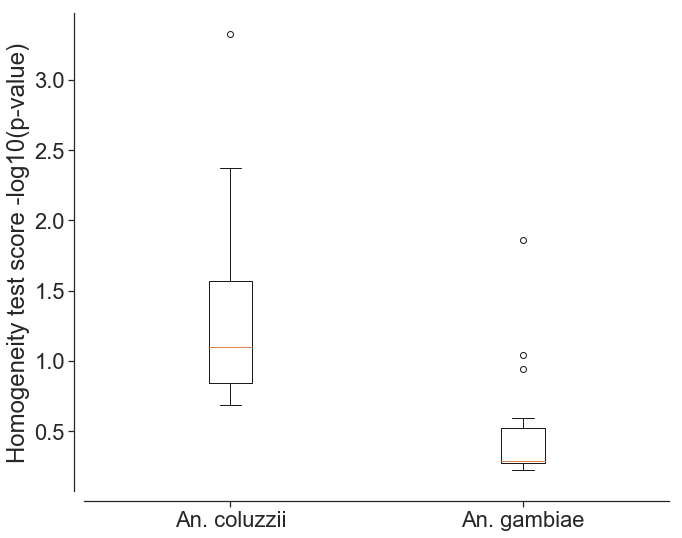

In [105]:
fig, ax = plt.subplots(figsize=(10, 8))
gambiae_hom = homogen_select_gambiae['score'].list()[:20]
coluzzii_hom  = homogen_select_coluzzii['score'].list()[:20]
ax.boxplot([coluzzii_hom, gambiae_hom])
#sns.boxplot([coluzzii_hom, gambiae_hom], ax=ax)
ax.set_xticklabels(['An. coluzzii', 'An. gambiae'])
ax.set_ylabel('Homogeneity test score -log10(p-value)')
sns.set(style ='ticks',font_scale=2)
sns.despine(offset=10)

fig.tight_layout()
#plt.savefig('/home/randomx/hka/homogen_test/distribution_top20_allgenes_v2.png', dpi=500)

## Plot the distribution of the homogen test genes under private selection

In [97]:
priv_sel_gambiae

chrom,gene,segreg_c,pri_der_fix_c,score_c,segreg_g,pri_der_fix_g,score_g
X,AGAP000975,None,None,0,14,5,32.3304107603
X,AGAP000949,None,None,0,11,4,25.0028562946
X,AGAP001068,27,1,0.236803556905,13,4,21.9914805256
X,AGAP001083,9,1,0.831281434198,6,3,21.6263518313
3R,AGAP010308,None,None,0,32,5,16.111339143


In [98]:
private_hom_gambiae = homogen_select_gambiae.join(priv_sel_gambiae, key='gene').sort('score', reverse=True)
private_hom_gambiae.rowlengths()

length,count
10,20


In [99]:
private_hom_coluzzii = homogen_select_coluzzii.join(priv_sel_coluzzii, key='gene').sort('score', reverse=True)
private_hom_coluzzii.rowlengths()

length,count
10,19


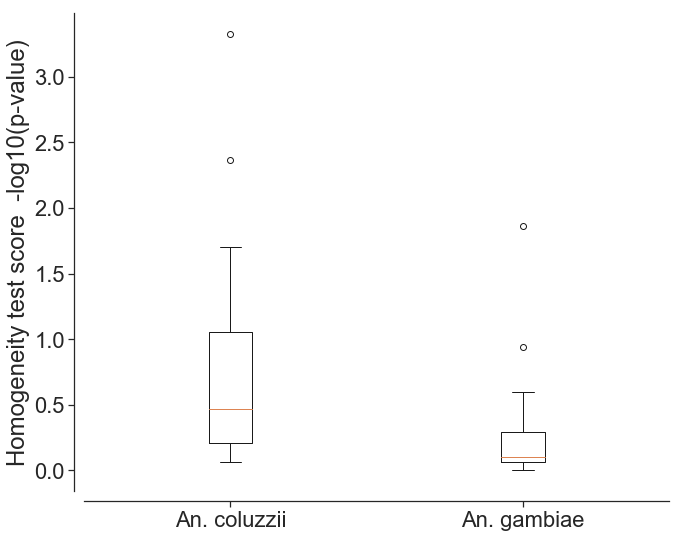

In [104]:
fig, ax = plt.subplots(figsize=(10,8))
gambiae_hom = private_hom_gambiae['score'].list()[:19]
coluzzii_hom  = private_hom_coluzzii['score'].list()
ax.boxplot([coluzzii_hom, gambiae_hom])
#sns.boxplot([coluzzii_hom, gambiae_hom], ax=ax)
ax.set_xticklabels(['An. coluzzii', 'An. gambiae'])
ax.set_ylabel('Homogeneity test score  -log10(p-value)')
sns.set(style ='ticks',font_scale=2)
sns.despine(offset=10)
fig.tight_layout()
#plt.savefig('/home/randomx/hka/homogen_test/distribution_top11_private_selec_v2.png', dpi=500)

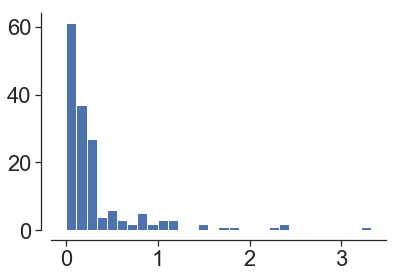

In [101]:
#plot homog score distribution
fig, ax = plt.subplots()
x = [float(i) for i in homog_tbl['score'].list()]
val = ax.hist(x, bins=30)
sns.despine(offset=10)